# 2025 CITS4012 Project 2: Group 17
Authors:
- Mitchell Otley (23475725)

- James Wigfield (23334375)

- Mahit Gupta    (23690265)

# Readme
If running in Google Colab, you may need to restart the kernel after importing gensim for the first time. It is also recommended to run with a GPU attached.

# 1.Dataset Processing
1.1 Import Libraries
Libraries are imported for the entire project here. The seed for randomisation is also set.

In [1]:
%pip install gensim
import gensim.downloader as api

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import sys
import time
import torch
import spacy
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from dataclasses import dataclass, asdict
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import json
import os
import math

torch.manual_seed(42)
random.seed(42)

Note: you may need to restart the kernel to use updated packages.


### 1.2. Retrieve Data
First, we need to retrieve the train/val/test datafiles from the Google Drive.

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_fileid = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
val_fileid = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
test_fileid = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"

train_file = drive.CreateFile({'id': train_fileid})
val_file = drive.CreateFile({'id': val_fileid})
test_file = drive.CreateFile({'id': test_fileid})

train_file.GetContentFile('train.json')
val_file.GetContentFile('val.json')
test_file.GetContentFile('test.json')

### 1.3. Read in the Data
We now read in each dataset, splitting the input data and target data. The data shapes are shown below.

In [3]:
train = pd.read_json('train.json')
X_train = train[['premise', 'hypothesis']]
y_train = train['label']

val = pd.read_json('val.json')
X_val = val[['premise', 'hypothesis']]
y_val = val['label']

test = pd.read_json('test.json')
X_test = test[['premise', 'hypothesis']]
y_test = test['label']

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (23088, 2)
Val shape: (1304, 2)
Test shape: (2126, 2)


### 1.4. Data preprocessing
As seen above, the data contains characters that requires cleaning before passing it to the model.

The preprocessing pipeline is as follows:
- Sentences are tokenised using SpaCy.
- A vocabulary list is constructed, including a padding and out-of-vocabulary tag.
- A GloVe Embedding model is loaded, pretrained on twitter.
- Tokenised sentences are converted to an indexed list of words, padded to the maximum size of the premise and hypothesis, respectively.

The labels are also converted to 0 or 1 (0 = neutral, 1 = entails).

#### 1.4.1. SpaCy Tokenisation
We tokenise the premises and hypotheses for the datasets - removing all non alphanumeric characters and converting words to lower case. Stopwords are removed, to remove words that do not contribute meaningfully to sentence interpretation.

In [4]:
spacy.cli.download('en_core_web_sm')
tokeniser = spacy.load('en_core_web_sm')

for dataset in [X_train, X_val, X_test]:
    premise_list = dataset['premise'].tolist()
    hypothesis_list = dataset['hypothesis'].tolist()

    prem_tokens_list = list(tokeniser.pipe(premise_list, batch_size=64))
    dataset.loc[:, "premise"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in prem_tokens_list]

    hyp_tokens_list = list(tokeniser.pipe(hypothesis_list, batch_size=64))
    dataset.loc[:, "hypothesis"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in hyp_tokens_list]

print(X_train.head)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
<bound method NDFrame.head of                                                  premise  \
0      [pluto, rotates, once, on, its, axis, every, e...   
1      [once, per, day, the, earth, rotates, about, i...   
2      [geysers, periodic, gush, of, hot, water, at, ...   
3      [facts, liquid, water, droplets, can, be, chan...   
4      [by, comparison, the, earth, rotates, on, its,...   
...                                                  ...   
23083  [which, is, not, only, the, motion, of, our, b...   
23084  [the, red, star, that, celestial, curse, whose...   
23085  [the, lines, in, the, spectrum, of, a, luminou...   
23086  [the, radial, velocity, of,

#### 1.4.2. Vocabulary Construction
We construct the vocabulary from the training set words. Each unique word is assigned an index, as well as custom words ['PAD'] and ['OOV'], which will be used later.

In [5]:
vocab_set = set([])
for tokens in X_train['premise']:
    for token in tokens:
        vocab_set.add(token)
for tokens in X_train['hypothesis']:
    for token in tokens:
        vocab_set.add(token)

# Convert the set to a list
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(vocab_set))

wordindexes = {word: i for i, word in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 20127


#### 1.4.3 Embedding Table Creation
We load the GloVe embeddings, and then for each word in the training set vocabulary, we add the embedding to our lookup table. If a word in the vocabulary does not exist in the GloVe embeddings, it is embedded as zeros.

In [6]:
glove_embeddings = api.load("glove-twitter-100")

emb_dim = glove_embeddings.vector_size
emb_table = []
for i, word in enumerate(vocab):
    if word in glove_embeddings:
        emb_table.append(glove_embeddings[word])
    else:
        emb_table.append(np.zeros(emb_dim))

emb_table = np.array(emb_table)
emb_table.shape

(20127, 100)

Later, we can now create an Embedding object that can be used to lookup the embeddings for any given word. This saves us from having to load the entire vocabulary embeddings at once during training.

### 1.5. Data visualisation
We will visualise the data to observe any patterns that we should be aware of before preprocessing and training.

First, lets observe the class balance for the train/val/test sets.

In [7]:
print(
    "Training set distribution:\n"
    f"Neutral = {round(y_train[y_train == 'neutral'].shape[0] / y_train.shape[0],2)}\n"
    f"Entails = {round(y_train[y_train == 'entails'].shape[0] / y_train.shape[0],2)}\n"
    "Validation set distribution:\n"
    f"Neutral = {round(y_val[y_val == 'neutral'].shape[0] / y_val.shape[0],2)}\n"
    f"Entails = {round(y_val[y_val == 'entails'].shape[0] / y_val.shape[0],2)}\n"
    "Testing set distribution:\n"
    f"Neutral = {round(y_test[y_test == 'neutral'].shape[0] / y_test.shape[0],2)}\n"
    f"Entails = {round(y_test[y_test == 'entails'].shape[0] / y_test.shape[0],2)}\n"
)

Training set distribution:
Neutral = 0.63
Entails = 0.37
Validation set distribution:
Neutral = 0.5
Entails = 0.5
Testing set distribution:
Neutral = 0.6
Entails = 0.4



The training and testing sets are skewed towards neutral samples - this may have an impact on training.

Now, we will observe the distribution of the token lengths of the premises and hypotheses of the train and validation sets.

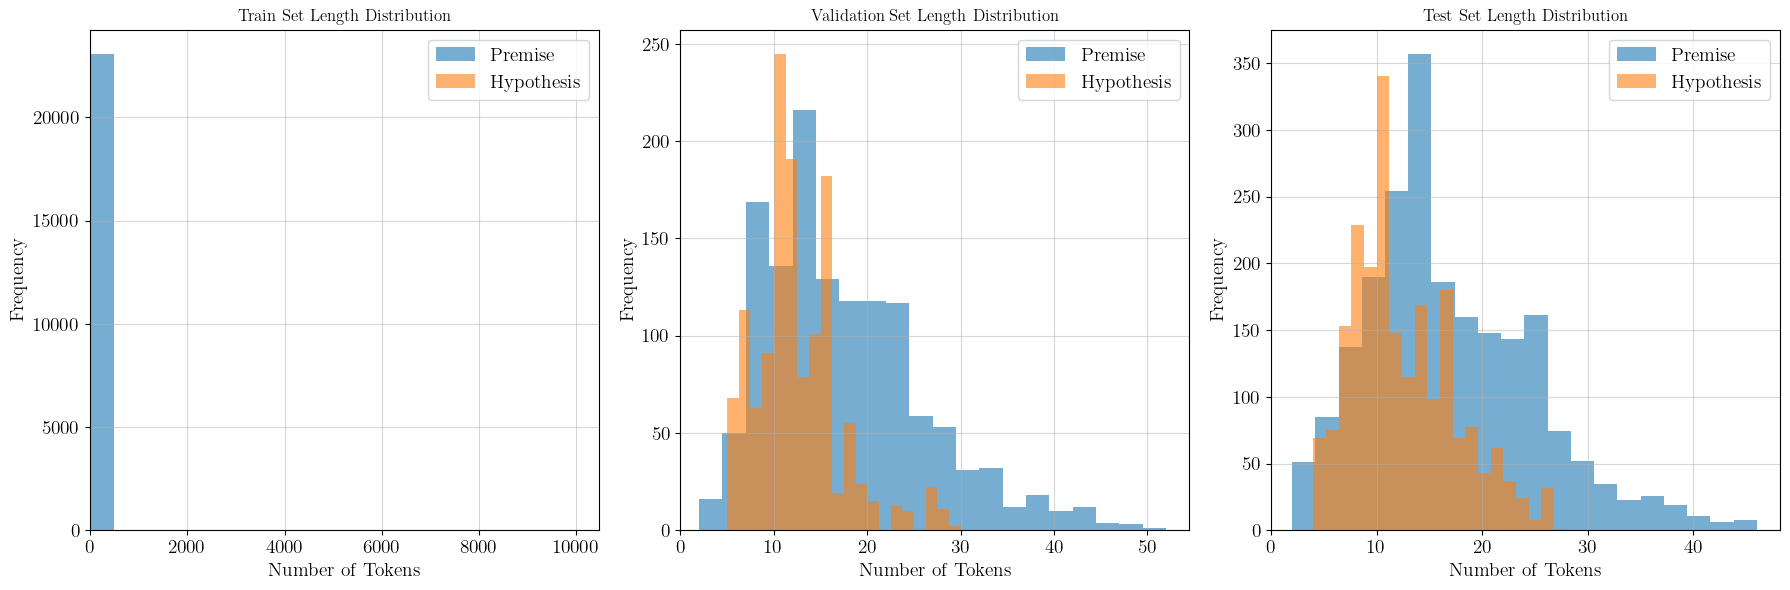

In [8]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

val_prem_lengths = [len(premise) for premise in X_val['premise']]
val_hyp_lengths = [len(hypothesis) for hypothesis in X_val['hypothesis']]

test_prem_lengths = [len(premise) for premise in X_test['premise']]
test_hyp_lengths = [len(hypothesis) for hypothesis in X_test['hypothesis']]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")

axs[2].hist(test_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[2].hist(test_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[2].set_title("Test Set Length Distribution")

for ax in axs:
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel("Number of Tokens", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_xlim(0)
    ax.legend(fontsize=14)
    ax.grid(zorder=0, alpha=0.5)

plt.tight_layout()
plt.show()

This indicates there are some outliers in the train set, with abnormally large numbers of tokens. To remove outliers (both small and large outliers), we removed the smallest and largest 2.5% of premises from the training set. Their corresponding hypotheses are also removed.

In [9]:
lower_prem, upper_prem = np.percentile(train_prem_lengths, [2.5, 97.5])
keep_indices = [i for i, pl in enumerate(train_prem_lengths) if lower_prem <= pl <= upper_prem]
X_train = X_train.iloc[keep_indices].reset_index(drop=True)
y_train = y_train.iloc[keep_indices].reset_index(drop=True)

Removing these outliers from the training set, we get a nicer looking plot:

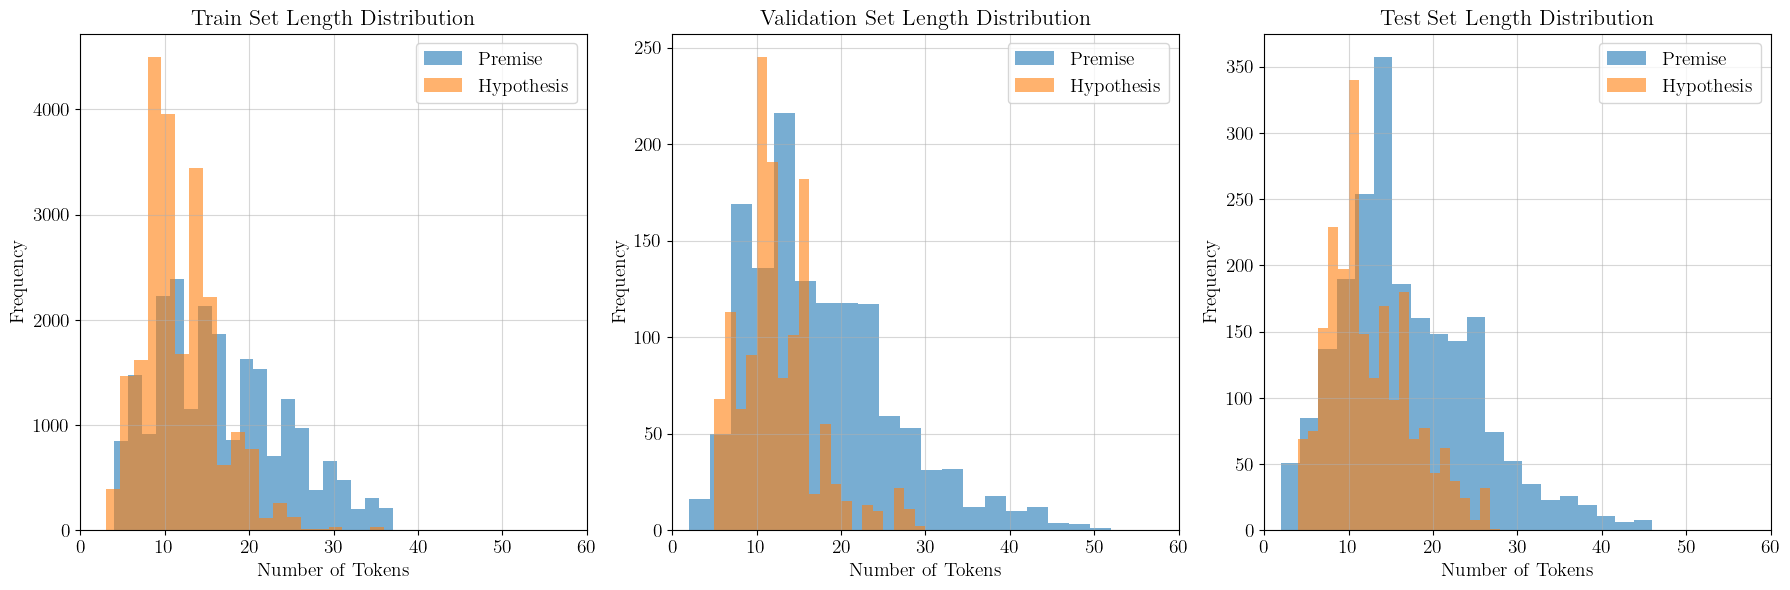

In [10]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
min_length = 0
max_length = 60
xticks = np.arange(min_length, max_length+10, 10)

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution", fontsize=16)

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution", fontsize=16)

axs[2].hist(test_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[2].hist(test_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[2].set_title("Test Set Length Distribution", fontsize=16)

for ax in axs:
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel("Number of Tokens", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_xticks(xticks)
    ax.set_xlim(0)
    ax.legend(fontsize=14)
    ax.grid(zorder=0, alpha=0.5)

plt.tight_layout()
plt.show()

### 1.6. Dataset Formation
Now we create the training dataset. The tokenised premise and hypothesis sentences are encoded to be the index that corresponds to the word embedding in the embeddings table. Each sentence is then padded to be the same length as the longest respective premise or hypothesis.

In [11]:
def encode_sentences(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append([wordindexes[word] if word in wordindexes else wordindexes['[OOV]'] for word in sentence])
    return encoded_sentences

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [wordindexes['[PAD]']] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences

max_prem_train = max(len(sentence) for sentence in X_train['premise'])
max_hyp_train = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_train = pad_sequences(encode_sentences(X_train['premise']), max_prem_train)
encoded_hyp_train = pad_sequences(encode_sentences(X_train['hypothesis']), max_hyp_train)

max_prem_val = max(len(sentence) for sentence in X_train['premise'])
max_hyp_val = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_val = pad_sequences(encode_sentences(X_val['premise']), max_prem_val)
encoded_hyp_val = pad_sequences(encode_sentences(X_val['hypothesis']), max_hyp_val)

The labels are converted to 0 for neutral, and 1 for entails.

In [12]:
y_train = y_train.map({'neutral': 0, 'entails': 1})
y_val = y_val.map({'neutral': 0, 'entails': 1})
y_test = y_test.map({'neutral': 0, 'entails': 1})

Now we can create the dataset and data loaders for the train and validation set. A batch size of 64 is used for the data loaders when passing the data to the models.

In [13]:
batch_size = 64

train_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_train), torch.tensor(encoded_hyp_train), torch.tensor(y_train.values))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

val_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_val), torch.tensor(encoded_hyp_val), torch.tensor(y_val.values))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

Class weighting is calculated based on the inverse proportion of instances of each sample in the training dataset. This will be passed to the loss function for balancing.

In [14]:
class_counts = torch.bincount(torch.tensor(y_train.values))
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_weights)

label_names = {0: "neutral", 1: "entails"}
for i in range(len(class_counts)):
    print(f"Class {i} ({label_names[i]}): count={class_counts[i].item()}, weight={class_weights[i].item():.6f}")

Class 0 (neutral): count=13914, weight=0.746374
Class 1 (entails): count=8284, weight=1.253626


### 1.7 Test Dataset
Finally, we create the test dataset in a similar way the training and validation sets are created.

In [15]:
max_prem = max(len(sentence) for sentence in X_test['premise'])
max_hyp = max(len(sentence) for sentence in X_test['hypothesis'])
encoded_prem_test = pad_sequences(encode_sentences(X_test['premise']), max_prem)
encoded_hyp_test = pad_sequences(encode_sentences(X_test['hypothesis']), max_hyp)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_test), torch.tensor(encoded_hyp_test), torch.tensor(y_test.values))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# 2. Model Implementation
Each model is implemented here.
## 2.1. Bidirectional GRU

In [16]:
class BiGRU(torch.nn.Module):
    def __init__(self, embedding_dim, individual_dim=256, combined_dim=128, linear_dim=64, num_layers=5, dropout=0.4):
        super(BiGRU, self).__init__()
        # Embedding layer
        self.embeddings = torch.nn.Embedding(len(vocab), embedding_dim, padding_idx=wordindexes['[PAD]'])
        self.embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.embeddings.weight.requires_grad = False

        # Premise and Hypothesis Pathways - GRU followed by Layer Normalisation
        self.prem_gru = torch.nn.GRU(embedding_dim, individual_dim, num_layers, batch_first=True, bidirectional=True)
        self.hyp_gru = torch.nn.GRU(embedding_dim, individual_dim, num_layers, batch_first=True, bidirectional=True)
        self.prem_norm = torch.nn.LayerNorm(individual_dim * 2) # x2 for forward and backward GRU
        self.hyp_norm = torch.nn.LayerNorm(individual_dim * 2) 

        # Combined GRU and Layer Normalisation
        self.combined_gru = torch.nn.GRU(individual_dim * 2, combined_dim, num_layers, batch_first=True, bidirectional=True)
        self.combined_norm = torch.nn.LayerNorm(combined_dim * 2)

        # MLP classification head
        self.mlp = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.Linear(combined_dim * 2, linear_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(linear_dim, 2),
        )

    def forward(self, prem, hyp):
        prem = self.embeddings(prem)
        hyp = self.embeddings(hyp)

        prem_out, _ = self.prem_gru(prem)
        hyp_out, _ = self.hyp_gru(hyp)
        prem_out = self.prem_norm(prem_out)
        hyp_out = self.hyp_norm(hyp_out)

        merged_out = torch.cat((prem_out, hyp_out), dim=1)
        merged_out, _ = self.combined_gru(merged_out)
        merged_out = self.combined_norm(merged_out)
        merged_out = torch.max(merged_out, dim=1)[0]

        logits = self.mlp(merged_out)
        return logits

## 2.2. Variational Siamese Autoencoder
This section implements the Variational Siamese Encoder for NLI. Each sentence is encoded by a BiLSTM into a latent distribution (μ, logσ²). A latent vector z is sampled using the reparameterization trick. The premise and hypothesis encodings are then combined and passed through an MLP classifier. Training uses cross-entropy plus KL divergence to regularize the latent space.

In [17]:
# Mean-pooling layer that ignores padding tokens via a mask
class MaskedMeanPool(nn.Module):
    def forward(self, x, mask):
        # x: [B,L,H], mask: [B,L] (1=real, 0=pad)
        mask = mask.float().unsqueeze(-1)
        x = x * mask # zero-out pads
        denom = mask.sum(dim=1).clamp_min(1e-6) #avoid zero-division
        return x.sum(dim=1) / denom #mean of reaal tokens

# BiLSTM sentence encoder with masked mean pooling over token states
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden=256, layers=1, bidir=True, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)  # PAD=0
        self.lstm = nn.LSTM(
            input_size = emb_dim,
            hidden_size = hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=dropout if layers > 1 else 0.0 # dropout only if layers > 1
        )

        self.out_dim = hidden * (2 if bidir else 1)
        self.mean_pool = MaskedMeanPool()  # expects (seq, mask) -> [B,D]

    def forward(self, ids):
        # ids: [B,L], lengths: [B]
        emb = self.embed(ids)  # [B,L,E]
        seq, _ = self.lstm(emb)
        mask = (ids != 0).long()  # [B,L], 1 for real tokens
        s = self.mean_pool(seq, mask)  # [B,D]
        return s
# Variational Siamese NLI model: encodes both sentences, reparameterizes z, then classifies their relation
class VariationalSiameseEncoder(nn.Module):
    def __init__(self, encoder, H, D, mlp_hidden=128, dropout=0.1, recon="none", gamma=0.0):
        super().__init__()
        self.encoder = encoder           # shared sentence encoder
        self.mu = nn.Linear(H, D)       # mean head over sentence rep s
        self.logvar = nn.Linear(H, D)   # log-variance head over s
        self.classifier = nn.Sequential(
            nn.Linear(2*D + 2*H, CFG.mlp_hidden),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(CFG.mlp_hidden, 2)
        )
        self.recon = recon
        self.gamma = gamma
        if self.recon == "feat":
            emb_dim = self.encoder.embed.embedding_dim
            self.rec_head = nn.Sequential(
                nn.Linear(D, H), nn.ReLU(),
                nn.Linear(H, emb_dim)
            )
        else:
            self.rec_head = None

    def _encode(self, s):
        return self.mu(s), self.logvar(s)

    def _reparam(self, mu, logv, use_mu_inference=False):
        if use_mu_inference:    # deterministic path at eval
            return mu
        std = (0.5 * logv).exp()
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, batch, beta=0.01, use_mu_inference=False):
        premises = batch[0]
        hypotheses = batch[1] 
        # encode premise and hypothesis -> sentence reps s1, s2
        s1 = self.encoder(premises)  
        s2 = self.encoder(hypotheses)

        # VAE heads + reparameterization for each side
        mu1, logv1 = self._encode(s1)
        mu2, logv2 = self._encode(s2)
        z1 = self._reparam(mu1, logv1, use_mu_inference)
        z2 = self._reparam(mu2, logv2, use_mu_inference)


        # pair features: |z1−z2|, z1·z2 plus raw s1,s2 (helps classifier)
        feat = torch.cat([torch.abs(z1 - z2), z1 * z2, s1, s2], dim=-1)
        logits = self.classifier(feat)

        if len(batch) != 3:
            return {"logits": logits}

        labels = batch[2]

        ce = F.cross_entropy(logits, labels, weight=CFG.class_weights)
        # KL for each side (diag Gaussian vs. N(0, I))
        kl1 = 0.5 * torch.sum(torch.exp(logv1) + mu1**2 - 1. - logv1, dim=1).mean()
        kl2 = 0.5 * torch.sum(torch.exp(logv2) + mu2**2 - 1. - logv2, dim=1).mean()
        kl  = kl1 + kl2

        # feature reconstruction loss (hypothesis side)
        rec = torch.tensor(0.0, device=logits.device)
        if self.recon == "feat" and self.rec_head is not None and self.gamma > 0.0:
            # masked mean of hypothesis *embeddings* (no grad)
            with torch.no_grad():
                emb = self.encoder.embed(batch[1])           # [B, L, E]
                mask = (batch[1] != 0).float().unsqueeze(-1) # PAD=0
                emb_masked = emb * mask
                denom = mask.sum(dim=1).clamp_min(1e-6)
                h_bow = emb_masked.sum(dim=1) / denom                 # [B, E]
            # predict it from z2
            h_hat = self.rec_head(z2)                                  # [B, E]
            rec = F.mse_loss(h_hat, h_bow)

        loss = ce + beta * kl + self.gamma * rec

        return {"logits": logits, "loss_total": loss, "loss_task": ce, "loss_kl": kl, "loss_rec": rec}

## 2.3. Transformer with Self-Attention and Stable Pooling

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class NLITransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead, nhid, nlayers, emb_table, dropout=0.3, freeze_embeddings=True):
        super(NLITransformer, self).__init__()
        
        # Embedding layer with scaling
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.emb_scale = math.sqrt(emb_dim)
        
        if emb_table is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # Add positional encoding
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)
        
        # Layer normalization for stability
        self.emb_layer_norm = nn.LayerNorm(emb_dim)
        
        # Transformer encoder with layer normalization
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        # Attention-weighted pooling with initialization
        self.attention_weights = nn.Linear(emb_dim, 1)
        nn.init.xavier_uniform_(self.attention_weights.weight, gain=0.01)
        nn.init.zeros_(self.attention_weights.bias)
        
        # Classifier with layer norm
        self.pre_classifier_layernorm = nn.LayerNorm(emb_dim)
        self.fc = nn.Linear(emb_dim, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize classifier
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def attention_pooling(self, encoder_output, mask=None):
        """
        Numerically stable attention-weighted pooling
        """
        batch_size, seq_len, emb_dim = encoder_output.size()
        
        # Calculate attention scores
        attention_scores = self.attention_weights(encoder_output).squeeze(-1)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask, -1e4)
            
            # Check if entire sequence is padding
            valid_tokens = ~mask
            has_valid = valid_tokens.any(dim=1, keepdim=True)
            
            # If no valid tokens, return zeros
            if not has_valid.all():
                attention_weights = torch.zeros_like(attention_scores)
                attention_weights = attention_weights.masked_fill(~has_valid.expand_as(attention_weights), 1.0/seq_len)
            else:
                # softmax
                attention_scores_max = attention_scores.max(dim=1, keepdim=True)[0]
                attention_scores = attention_scores - attention_scores_max
                attention_weights = torch.softmax(attention_scores, dim=1)
                
                # Zero out padding positions after softmax
                attention_weights = attention_weights.masked_fill(mask, 0)
                
                # Renormalize
                attention_weights = attention_weights / (attention_weights.sum(dim=1, keepdim=True) + 1e-8)
        else:
            attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Weighted sum
        weighted_output = torch.bmm(
            attention_weights.unsqueeze(1),
            encoder_output
        ).squeeze(1)
        
        return weighted_output
    
    def forward(self, premise, hypothesis):
        # Create padding masks
        premise_mask = (premise == 0)
        hypothesis_mask = (hypothesis == 0)
        
        # Embed and scale
        premise_emb = self.embedding(premise) * self.emb_scale
        hypothesis_emb = self.embedding(hypothesis) * self.emb_scale
        
        # Apply layer norm to embeddings
        premise_emb = self.emb_layer_norm(premise_emb)
        hypothesis_emb = self.emb_layer_norm(hypothesis_emb)
        
        # Concatenate
        combined = torch.cat([premise_emb, hypothesis_emb], dim=1)
        combined_mask = torch.cat([premise_mask, hypothesis_mask], dim=1)
        
        # Transform
        encoded = self.transformer_encoder(combined, src_key_padding_mask=combined_mask)
        
        # Safe attention pooling
        pooled = self.attention_pooling(encoded, mask=combined_mask)
        
        # Layer norm before classifier
        pooled = self.pre_classifier_layernorm(pooled)
        
        # Classify
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        
        return logits

And the cross-attention transformer for the ablation study.

In [19]:
class NLITransformerCrossAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead, nhid, nlayers, emb_table, dropout=0.3, freeze_embeddings=True):
        super(NLITransformerCrossAttention, self).__init__()
        
        # Embedding layer with scaling
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.emb_scale = math.sqrt(emb_dim)
        
        if emb_table is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # Layer normalization
        self.emb_layer_norm = nn.LayerNorm(emb_dim)
        
        # Separate encoders with pre-LN
        encoder_layers_premise = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.premise_encoder = nn.TransformerEncoder(encoder_layers_premise, nlayers)
        
        encoder_layers_hypothesis = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.hypothesis_encoder = nn.TransformerEncoder(encoder_layers_hypothesis, nlayers)
        
        # Cross-attention with dropout
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=emb_dim,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        
        # Layer norm after cross-attention
        self.cross_attn_layer_norm = nn.LayerNorm(emb_dim)
        
        # Attention pooling with proper initialization
        self.premise_attention_weights = nn.Linear(emb_dim, 1)
        self.hypothesis_attention_weights = nn.Linear(emb_dim, 1)
        
        # Initialize with small weights
        for module in [self.premise_attention_weights, self.hypothesis_attention_weights]:
            nn.init.xavier_uniform_(module.weight, gain=0.01)
            nn.init.zeros_(module.bias)
        
        # Classifier
        self.pre_classifier_layernorm = nn.LayerNorm(emb_dim * 2)
        self.fc = nn.Linear(emb_dim * 2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize classifier
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def attention_pooling(self, encoder_output, attention_layer, mask=None):
        """
        Attention pooling
        """
        batch_size, seq_len, emb_dim = encoder_output.size()
        
        # Calculate attention scores
        attention_scores = attention_layer(encoder_output).squeeze(-1)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask, -1e4)
            
            # Check for sequences with all padding
            valid_tokens = ~mask
            has_valid = valid_tokens.any(dim=1, keepdim=True)
            
            if not has_valid.all():
                attention_weights = torch.zeros_like(attention_scores)
                attention_weights = attention_weights.masked_fill(~has_valid.expand_as(attention_weights), 1.0/seq_len)
            else:
                # Numerical stability for softmax
                attention_scores_max = attention_scores.max(dim=1, keepdim=True)[0]
                attention_scores = attention_scores - attention_scores_max
                attention_weights = torch.softmax(attention_scores, dim=1)
                
                # Mask and renormalize
                attention_weights = attention_weights.masked_fill(mask, 0)
                attention_weights = attention_weights / (attention_weights.sum(dim=1, keepdim=True) + 1e-8)
        else:
            attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Weighted sum
        weighted_output = torch.bmm(
            attention_weights.unsqueeze(1),
            encoder_output
        ).squeeze(1)
        
        return weighted_output
    
    def forward(self, premise, hypothesis):
        # Padding masks
        premise_mask = (premise == 0)
        hypothesis_mask = (hypothesis == 0)
        
        # Embed and scale
        premise_emb = self.embedding(premise) * self.emb_scale
        hypothesis_emb = self.embedding(hypothesis) * self.emb_scale
        
        # Layer norm
        premise_emb = self.emb_layer_norm(premise_emb)
        hypothesis_emb = self.emb_layer_norm(hypothesis_emb)
        
        # Encode separately
        premise_encoded = self.premise_encoder(premise_emb, src_key_padding_mask=premise_mask)
        hypothesis_encoded = self.hypothesis_encoder(hypothesis_emb, src_key_padding_mask=hypothesis_mask)
        
        # Cross-attention with residual connection
        cross_attended, _ = self.cross_attention(
            query=hypothesis_encoded,
            key=premise_encoded,
            value=premise_encoded,
            key_padding_mask=premise_mask
        )
        
        # Add residual and layer norm
        cross_attended = self.cross_attn_layer_norm(cross_attended + hypothesis_encoded)
        
        # attention pooling
        premise_pooled = self.attention_pooling(
            premise_encoded,
            self.premise_attention_weights,
            mask=premise_mask
        )
        hypothesis_pooled = self.attention_pooling(
            cross_attended,
            self.hypothesis_attention_weights,
            mask=hypothesis_mask
        )
        
        # Concatenate
        combined = torch.cat([premise_pooled, hypothesis_pooled], dim=1)
        
        # Layer norm and classify
        combined = self.pre_classifier_layernorm(combined)
        combined = self.dropout(combined)
        logits = self.fc(combined)
        
        return logits

# 3.Testing and Evaluation
## 3.1. Bidirectional GRU
The Bidirectional GRU training function:

In [20]:
# Training function for Bidirectional GRU
def train_gru(model, optimiser, scheduler, epochs, criterion, train_loader, val_loader, device):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        start_time = time.time()
        # Train loop
        for i, batch in enumerate(train_loader):
            if i % 100 == 0:
                sys.stdout.write(f"\rEpoch: ({(epoch + 1):02} / {epochs:02}) | Batch: ({i} / {len(train_loader)}) | Loss: {train_loss / (i+1)}")
                sys.stdout.flush()
            premises = batch[0].to(device)
            hypotheses = batch[1].to(device)
            labels = batch[2].to(device).long()

            optimiser.zero_grad()
            outputs = model(premises, hypotheses)

            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimiser.step()
        # Val loop
        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct = 0
            for batch in val_loader:
                premises = batch[0].to(device)
                hypotheses = batch[1].to(device)
                labels = batch[2].to(device).long()
                outputs = model(premises, hypotheses)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_acc = correct / len(val_loader.dataset)
        epoch_time = (time.time() - start_time)
        epoch_min = int(epoch_time // 60)
        epoch_sec = int(epoch_time % 60)
        train_loss = train_loss / len(train_loader)
        if scheduler is not None:
            scheduler.step()
        sys.stdout.write(f"\rEpoch: ({(epoch + 1):02} / {epochs:02}) | Time: {epoch_min:02d}:{epoch_sec:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}\n")
    
    # Return final validation loss
    return val_loss

The following hyperparameters were selected after performing tuning:
- individual_dim=256
- combined_dim=128
- linear_dim=64
- num_layers=5
- dropout=0.4
The model is trained for 10 epochs with an ADAM optimiser, with an initial learning rate of 1e-5.

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights = class_weights.to(device)
hyperparams = [256, 128, 64, 5, 0.4]
epochs = 10
model = BiGRU(emb_dim, individual_dim=hyperparams[0], combined_dim=hyperparams[1], linear_dim=hyperparams[2], num_layers=hyperparams[3], dropout=hyperparams[4])
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = None
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
val_loss = train_gru(model, optimiser, scheduler, epochs, criterion, train_loader, val_loader, device)

Epoch: (01 / 10) | Time: 00:20 | Train Loss: 0.6931 | Val Loss: 0.7011 | Val Accuracy: 0.55
Epoch: (02 / 10) | Time: 00:19 | Train Loss: 0.6742 | Val Loss: 0.7413 | Val Accuracy: 0.52
Epoch: (03 / 10) | Time: 00:18 | Train Loss: 0.6547 | Val Loss: 0.7070 | Val Accuracy: 0.59
Epoch: (04 / 10) | Time: 00:18 | Train Loss: 0.6430 | Val Loss: 0.6664 | Val Accuracy: 0.62
Epoch: (05 / 10) | Time: 00:17 | Train Loss: 0.6285 | Val Loss: 0.6820 | Val Accuracy: 0.63
Epoch: (06 / 10) | Time: 00:19 | Train Loss: 0.6180 | Val Loss: 0.6737 | Val Accuracy: 0.64
Epoch: (07 / 10) | Time: 00:18 | Train Loss: 0.6123 | Val Loss: 0.6837 | Val Accuracy: 0.64
Epoch: (08 / 10) | Time: 00:19 | Train Loss: 0.6055 | Val Loss: 0.6701 | Val Accuracy: 0.65
Epoch: (09 / 10) | Time: 00:19 | Train Loss: 0.5992 | Val Loss: 0.6636 | Val Accuracy: 0.66
Epoch: (10 / 10) | Time: 00:19 | Train Loss: 0.5900 | Val Loss: 0.6727 | Val Accuracy: 0.66


              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77      1284
         1.0       0.68      0.44      0.53       842

    accuracy                           0.70      2126
   macro avg       0.69      0.65      0.65      2126
weighted avg       0.69      0.70      0.68      2126



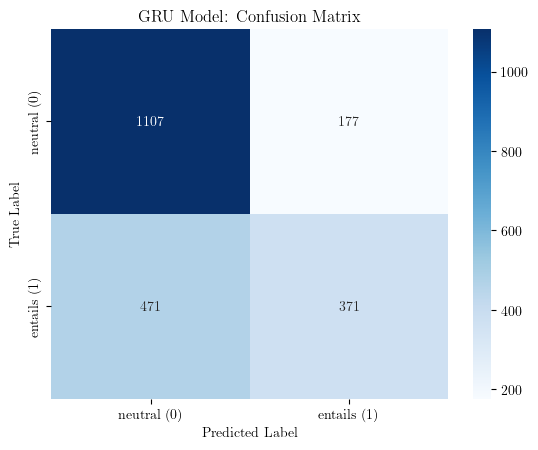

In [22]:
model.eval()

all_labels = []
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        premises = batch[0].to(device)
        hypotheses = batch[1].to(device)
        labels = batch[2].to(device).float()
        outputs = model(premises, hypotheses)
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy().flatten())
        all_predictions.extend(preds.cpu().numpy().flatten())

print(classification_report(all_labels, all_predictions))

labels = ["neutral (0)", "entails (1)"]
cm = confusion_matrix(all_labels, all_predictions, labels=[0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GRU Model: Confusion Matrix")
plt.show()

## 3.2. VSAE Model
The VSAE training function:

In [23]:
def default_run_name(prefix="run"):
    ts = time.strftime("%Y%m%d-%H%M%S")
    return f"{prefix}_{ts}"

@dataclass
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # --- tokenisation ---
    spacy_model: str = "en_core_web_sm"
    spacy_disable: tuple = ("ner","parser","tagger","lemmatizer")
    use_partner_regex: bool = True             
    token_filter_regex: str = r"^\w+$"        

    # encoder
    embedding_dim: int = 100
    lstm_hidden: int = 300
    lstm_layers: int = 1
    bidir: bool = True
    dropout: float = 0.1

    freeze_embeddings: bool = False

    #variational
    latent_dim: int = 128  
    beta: float = 0.004    

    # classifier
    mlp_hidden: int = 256

    # --- training / data ---
    lr: float = 2e-4
    weight_decay: float = 0.01
    epochs: int = 10
    batch_size: int = 64           

    # --- decoder ---
    recon: str = "feat" # {"none", "bow", "feat"}
    gamma: float = 0.3

    run_name: str = default_run_name("baseline")  # used for plots/logging
    class_weights: list = class_weights.to("cuda" if torch.cuda.is_available() else "cpu")

CFG = Config()
CFG.num_classes = 2
H = CFG.lstm_hidden * (2 if CFG.bidir else 1)

encoder = BiLSTMEncoder(
    vocab_size=len(vocab),
    emb_dim=CFG.embedding_dim,
    hidden=CFG.lstm_hidden,
    layers=CFG.lstm_layers,
    bidir=CFG.bidir,
    dropout=CFG.dropout
)

model = VariationalSiameseEncoder(
    encoder=encoder,
    H=H,
    D=CFG.latent_dim,     # latent z dim for each side
    mlp_hidden=CFG.mlp_hidden,
    dropout=CFG.dropout,
    recon=CFG.recon,
    gamma=CFG.gamma
).to(CFG.device)

def evaluate(model, loader, use_mu_inference=True):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = [batch[0].to(CFG.device), batch[1].to(CFG.device), batch[2].to(CFG.device)]
            out = model(batch, beta=CFG.beta, use_mu_inference=use_mu_inference)  # deterministic at eval
            preds = out["logits"].argmax(-1)
            labels = batch[2]
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / max(total, 1)

In [24]:
best_path = f"best_{CFG.run_name}.pt"
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

best_val = -1.0

for epoch in range(1, CFG.epochs+1):
    model.train()
    t0 = time.time()
    seen = 0
    loss_sum = task_sum = kl_sum = rec_sum = 0.0

    for batch in train_loader:
        batch = [batch[0].to(CFG.device), batch[1].to(CFG.device), batch[2].to(CFG.device)]

        warmup_epochs = max(1, int(0.3 * CFG.epochs)) # 30% of training
        beta_t = CFG.beta * min(1.0, epoch / warmup_epochs)  # linear warm-up over number of epochs

        out = model(batch, beta=beta_t, use_mu_inference=False)  # stochastic z during training
        rec_val = out.get("loss_rec", torch.tensor(0.0, device=CFG.device))
        loss = out["loss_total"]
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip to stabilise LSTM
        optimizer.step()

        bs = batch_size
        seen += bs
        loss_sum += out["loss_total"].item() * bs
        task_sum += out["loss_task"].item() * bs
        kl_sum += out["loss_kl"].item() * bs
        rec_sum += rec_val.item() * bs

    train_loss = loss_sum / max(1, seen)
    train_task = task_sum / max(1, seen)
    train_kl = kl_sum / max(1, seen)
    train_rec  = rec_sum  / max(1, seen)

    val_acc = evaluate(model, val_loader, use_mu_inference=True)
    print(f"Epoch {epoch:02d} | {time.time()-t0:.1f}s | loss={train_loss:.4f} (task={train_task:.4f}, kl={train_kl:.4f}) | rec={train_rec:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save({"state": model.state_dict(), "cfg": asdict(CFG)}, best_path)
        print("  saved best ->", best_path)

print("Best val acc:", best_val)
print("Best checkpoint:", best_path)

Epoch 01 | 6.4s | loss=0.7112 (task=0.6764, kl=0.3855) | rec=0.1145 | val_acc=0.6265
  saved best -> best_baseline_20251019-223223.pt
Epoch 02 | 5.4s | loss=0.6539 (task=0.6217, kl=0.3234) | rec=0.1044 | val_acc=0.6741
  saved best -> best_baseline_20251019-223223.pt
Epoch 03 | 5.3s | loss=0.5973 (task=0.5656, kl=0.2528) | rec=0.1025 | val_acc=0.6794
  saved best -> best_baseline_20251019-223223.pt
Epoch 04 | 5.4s | loss=0.5436 (task=0.5123, kl=0.2248) | rec=0.1013 | val_acc=0.6894
  saved best -> best_baseline_20251019-223223.pt
Epoch 05 | 5.6s | loss=0.4878 (task=0.4568, kl=0.2192) | rec=0.1004 | val_acc=0.6810
Epoch 06 | 6.0s | loss=0.4352 (task=0.4044, kl=0.2221) | rec=0.0995 | val_acc=0.6848
Epoch 07 | 5.6s | loss=0.3831 (task=0.3526, kl=0.2095) | rec=0.0988 | val_acc=0.6825
Epoch 08 | 5.7s | loss=0.3355 (task=0.3052, kl=0.2039) | rec=0.0982 | val_acc=0.6940
  saved best -> best_baseline_20251019-223223.pt
Epoch 09 | 5.3s | loss=0.2929 (task=0.2628, kl=0.1867) | rec=0.0977 | val_a

Now we evaluate on the test dataset:

Loaded best_baseline_20251019-223223.pt
Test accuracy: 0.6369
Confusion matrix (rows=true, cols=pred):
 [[773 511]
 [261 581]]
              precision    recall  f1-score   support

 neutral (0)      0.748     0.602     0.667      1284
 entails (1)      0.532     0.690     0.601       842

    accuracy                          0.637      2126
   macro avg      0.640     0.646     0.634      2126
weighted avg      0.662     0.637     0.641      2126



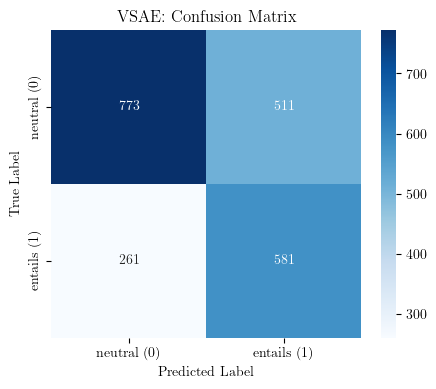

In [25]:
# load best
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=CFG.device)
    model.load_state_dict(ckpt["state"])
    print("Loaded", best_path)

# evaluate with deterministic inference (use μ)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = [batch[0].to(CFG.device), batch[1].to(CFG.device), batch[2].to(CFG.device)]
        out = model(batch, beta=CFG.beta, use_mu_inference=True)
        preds = out["logits"].argmax(-1).cpu().numpy()
        labs  = batch[2].cpu().numpy()
        all_preds.append(preds); all_labels.append(labs)

preds = np.concatenate(all_preds) if all_preds else np.array([])
labs  = np.concatenate(all_labels) if all_labels else np.array([])
acc = (preds == labs).mean() if preds.size else 0.0

cm = np.zeros((2,2), dtype=int)
for t,p in zip(labs, preds): cm[t,p] += 1

print(f"Test accuracy: {acc:.4f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)
report = classification_report(labs, preds, target_names=["neutral (0)", "entails (1)"], digits=3)
print(report)

labels = ["neutral (0)", "entails (1)"]
cm = confusion_matrix(labs, preds, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("VSAE: Confusion Matrix")
plt.show()

## 3.3. Ablation Study 1: Reconstruction Weight (γ) Variation
This first code block is the functions defined for the ablation study.

In [26]:
# ---------- Metrics ----------
def compute_metrics(model, loader, device=None, use_mu_inference=True, beta_for_eval=None, num_classes=2):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = [batch[0].to(CFG.device), batch[1].to(CFG.device), batch[2].to(CFG.device)]
            out = model(batch, beta=(beta_for_eval if beta_for_eval is not None else getattr(CFG,"beta",1.0)),
                        use_mu_inference=use_mu_inference)
            preds.append(out["logits"].argmax(-1).cpu().numpy())
            labels.append(batch[2].cpu().numpy())
    y_pred, y_true = np.concatenate(preds), np.concatenate(labels)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=list(range(num_classes)), zero_division=0)
    return {"accuracy": float(acc), "macro_f1": float(f1.mean() if len(f1) else 0.0),
            "per_class_f1": [float(x) for x in f1], "support": [int(x) for x in support]}

def timestamp():
    return time.strftime("%Y%m%d_%H%M%S")

def run_id_from_cfg(tag="gamma"):
    parts = [str(tag), f"ep{getattr(CFG,'epochs',10)}", f"bs{getattr(CFG,'batch_size',64)}",
             f"lr{getattr(CFG,'lr',1e-3)}", timestamp()]
    return "_".join(parts)

# ---------- Model + Dataloaders Builder ----------
def build_vsae_from_cfg():
    """
    Builds model + optimizer + loaders for a fresh run.
    Uses globals from earlier cells: encoder, H, train_ds, val_ds, test_ds, collate_bilstm, pad_id, MAX_LEN,
    and optional train_sampler.
    """
    model = VariationalSiameseEncoder(
        encoder=encoder,
        H=H,
        D=CFG.latent_dim,
        mlp_hidden=CFG.mlp_hidden,
        dropout=CFG.dropout,
        recon=CFG.recon,
        gamma=CFG.gamma
    ).to(CFG.device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=getattr(CFG, "lr", 1e-3),
                                  weight_decay=getattr(CFG, "weight_decay", 0.0))

    scheduler = None
    return model, train_loader, val_loader, test_loader, optimizer, scheduler

def train_full_run_and_return_paths(run_name: str):
    """
    Integrated version of your training loop:
    - β warm-up
    - grad clipping
    - CSV logging
    - best-by-val-acc checkpointing
    Expects globals from build_vsae_from_cfg(): model, train_loader, val_loader, test_loader, optimizer, scheduler
    """
    # ---- per-run output paths ----
    out_dir = f"runs/{run_name}"
    os.makedirs(out_dir, exist_ok=True)
    best_path = f"{out_dir}/best.pt"

    best_val = -1.0

    # ---------- TRAIN + EVAL LOOP ----------
    E = getattr(CFG, "epochs", 10)
    base_beta = float(getattr(CFG, "beta", 1.0))
    warmup_E  = int(getattr(CFG, "beta_warmup_epochs", 0))
    use_clip  = float(getattr(CFG, "grad_clip", 0.0))

    for epoch in range(1, E + 1):
        model.train()
        t_loss = t_task = t_kl = t_rec = 0.0
        n_batches = 0

        # ---- optional β warm-up ----
        if warmup_E > 0:
            beta = min(1.0, epoch / warmup_E) * base_beta
        else:
            beta = base_beta

        # ---- training epoch ----
        for batch in train_loader:
            n_batches += 1
            batch = [batch[0].to(CFG.device), batch[1].to(CFG.device), batch[2].to(CFG.device)]
            optimizer.zero_grad()

            out = model(batch, beta=beta, use_mu_inference=False)  # stochastic z for training

            # Retrieve loss tensors from the model output dictionary
            loss_total = out.get("loss_total")
            loss_task = out.get("loss_task", torch.tensor(0.0, device=CFG.device))
            loss_kl = out.get("loss_kl", torch.tensor(0.0, device=CFG.device))
            loss_rec_val = out.get("loss_rec", torch.tensor(0.0, device=CFG.device))

            loss = loss_total # Use the total loss for backpropagation

            loss.backward()
            if use_clip and use_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), use_clip)
            optimizer.step()

            # accumulate for logging
            t_loss += float(loss.detach().cpu().item())
            t_task += float(loss_task.detach().cpu().item())
            t_kl   += float(loss_kl.detach().cpu().item())
            t_rec  += float(loss_rec_val.detach().cpu().item())


        # ---- average epoch stats ----
        n_batches = max(1, n_batches)
        train_loss = t_loss / n_batches
        train_task = t_task / n_batches
        train_kl   = t_kl   / n_batches
        train_rec  = t_rec  / n_batches

        # ---- validation accuracy ----
        val_acc = None
        try:
            val_acc = float(evaluate(model, val_loader, use_mu_inference=True))
        except Exception:
            val_metrics = compute_metrics(model, val_loader, device=CFG.device, num_classes=getattr(CFG, "num_classes", 2))
            val_acc = float(val_metrics["accuracy"])

        print(f"[Epoch {epoch:03d}] beta={beta:.4f} | train: loss={train_loss:.4f} cls={train_task:.4f} kl={train_kl:.4f} rec={train_rec:.4f} | val_acc={val_acc:.4f}")

        # ---- checkpoint best ----
        if val_acc > best_val:
            best_val = val_acc
            torch.save({"state": model.state_dict(), "cfg": asdict(CFG)}, best_path)
            print("  saved best ->", best_path)

    print("Best val acc:", best_val)
    print("Best checkpoint:", best_path)
    return None, best_path

def run_single_gamma(gamma_value: float, pooling: str = None):
    """
    Sets γ, rebuilds model/loaders, trains, and evaluates.
    Returns a dict of metrics for one configuration.
    """
    CFG.gamma = float(gamma_value)
    if hasattr(CFG, "use_reconstruction"):
        CFG.use_reconstruction = (CFG.gamma > 0)
    if pooling is not None and hasattr(CFG, "pooling"):
        CFG.pooling = pooling

    model, train_loader, val_loader, test_loader, optimizer, scheduler = build_vsae_from_cfg()

    globals().update(dict(model=model, train_loader=train_loader,
                          val_loader=val_loader, test_loader=test_loader,
                          optimizer=optimizer, scheduler=scheduler))

    run_name = run_id_from_cfg(tag=f"gamma{gamma_value}".replace(".", "_"))
    log_path, best_path = train_full_run_and_return_paths(run_name)

    # Load best checkpoint and compute metrics
    best_state = torch.load(best_path, map_location=CFG.device)
    model.load_state_dict(best_state["state"])

    val_metrics = compute_metrics(model, val_loader, device=CFG.device, num_classes=CFG.num_classes)
    test_metrics = compute_metrics(model, test_loader, device=CFG.device, num_classes=CFG.num_classes)

    return dict(
        run=run_name,
        gamma=float(gamma_value),
        val_acc=val_metrics["accuracy"],
        val_macro_f1=val_metrics["macro_f1"],
        test_acc=test_metrics["accuracy"],
        test_macro_f1=test_metrics["macro_f1"],
        per_class_f1_val=json.dumps(val_metrics["per_class_f1"]),
        per_class_f1_test=json.dumps(test_metrics["per_class_f1"]),
        checkpoint=str(best_path),
        log_csv=log_path
    )


Now we run the tests for the following gamma values: [0.0, 0.1, 0.3, 0.5]

In [27]:
# ==== Run γ sweep ====
GAMMAS = [0.0, 0.1, 0.3, 0.5]
results = []

for g in GAMMAS:
    print(f"\n=== Running γ={g} ===")
    results.append(run_single_gamma(g))

res_df = pd.DataFrame(results)
os.makedirs("runs", exist_ok=True)


=== Running γ=0.0 ===
[Epoch 001] beta=0.0040 | train: loss=0.2732 cls=0.2712 kl=0.5085 rec=0.0000 | val_acc=0.7025
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_223322/best.pt
[Epoch 002] beta=0.0040 | train: loss=0.1904 cls=0.1892 kl=0.3081 rec=0.0000 | val_acc=0.7094
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_223322/best.pt
[Epoch 003] beta=0.0040 | train: loss=0.1567 cls=0.1556 kl=0.2788 rec=0.0000 | val_acc=0.6994
[Epoch 004] beta=0.0040 | train: loss=0.1512 cls=0.1501 kl=0.2682 rec=0.0000 | val_acc=0.6963
[Epoch 005] beta=0.0040 | train: loss=0.1722 cls=0.1711 kl=0.2731 rec=0.0000 | val_acc=0.7163
  saved best -> runs/gamma0_0_ep10_bs64_lr0.0002_20251019_223322/best.pt
[Epoch 006] beta=0.0040 | train: loss=0.1544 cls=0.1534 kl=0.2487 rec=0.0000 | val_acc=0.7147
[Epoch 007] beta=0.0040 | train: loss=0.1211 cls=0.1202 kl=0.2329 rec=0.0000 | val_acc=0.6902
[Epoch 008] beta=0.0040 | train: loss=0.0875 cls=0.0867 kl=0.2056 rec=0.0000 | val_acc=0.6956
[Epoch

Now we can plot the results of the study.

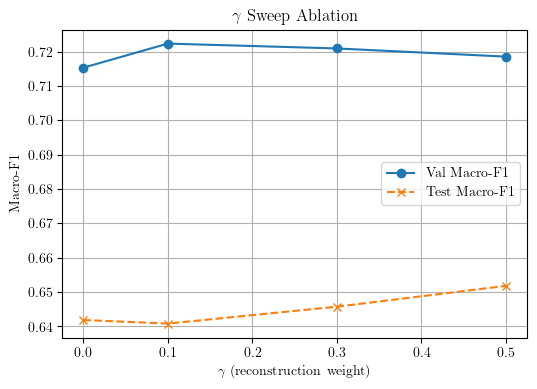

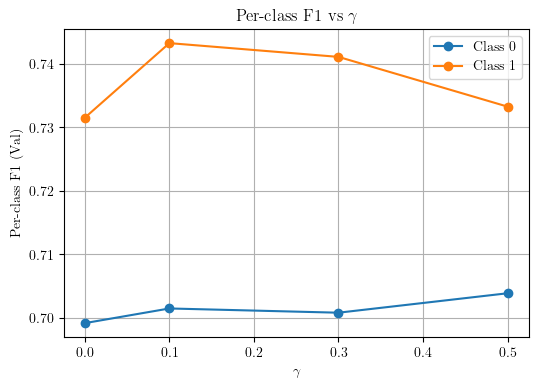

In [28]:
# ==== Plot Macro-F1 vs γ ====
plt.figure(figsize=(6,4))
plt.plot(res_df["gamma"], res_df["val_macro_f1"], marker="o", label="Val Macro-F1")
plt.plot(res_df["gamma"], res_df["test_macro_f1"], marker="x", linestyle="--", label="Test Macro-F1")
plt.xlabel(r"$\gamma$ (reconstruction weight)")
plt.ylabel("Macro-F1")
plt.title(r"$\gamma$ Sweep Ablation")
plt.legend()
plt.grid(True)
plt.show()

# ==== Per-class F1 (val) ====
plt.figure(figsize=(6,4))
expanded = []
for _, r in res_df.iterrows():
    per_f1 = json.loads(r["per_class_f1_val"])
    for i, f in enumerate(per_f1):
        expanded.append({"gamma": r["gamma"], "class": i, "f1": f})
per_df = pd.DataFrame(expanded)
for cls, sub in per_df.groupby("class"):
    plt.plot(sub["gamma"], sub["f1"], marker="o", label=f"Class {cls}")
plt.xlabel(r"$\gamma$")
plt.ylabel("Per-class F1 (Val)")
plt.title(r"Per-class F1 vs $\gamma$")
plt.legend()
plt.grid(True)
plt.show()


## 3.4. Transformer Model - Self-Attention and Cross-Attention
The transformer training function, for both the self-attention model and cross-attention model (for the ablation study).

In [29]:
# Hyperparameters
vocab_size = len(vocab)
emb_dim = 100
nhead = 4
nhid = 512
nlayers = 3
dropout = 0.3

# self-attention model
model = NLITransformer(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=nhead,
    nhid=nhid,
    nlayers=nlayers,
    emb_table=emb_table,
    dropout=dropout,
    freeze_embeddings=True
).to(device)

# cross-attention model
model_cross = NLITransformerCrossAttention(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=4,
    nhid=256,
    nlayers=2,
    emb_table=emb_table,
    dropout=0.2,
    freeze_embeddings=True
).to(device)

criterion = nn.CrossEntropyLoss()

def train_epoch(model, train_loader, optimizer, criterion, device, max_grad_norm=0.5):
    """Train for one epoch with aggressive gradient clipping"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (premises, hypotheses, labels) in enumerate(train_loader):
        premises = premises.to(device)
        hypotheses = hypotheses.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(premises, hypotheses)
        
        # Check for NaN
        if torch.isnan(logits).any():
            print(f"Warning: NaN in outputs at batch {batch_idx}, skipping...")
            continue
            
        loss = criterion(logits, labels)
        
        if torch.isnan(loss):
            print(f"Warning: NaN in loss at batch {batch_idx}, skipping...")
            continue
        
        # Backward pass
        loss.backward()
        
        # Aggressive gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        
        # Optimizer step
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / max(len(train_loader), 1)
    accuracy = correct / max(total, 1)
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for premises, hypotheses, labels in data_loader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            labels = labels.to(device)
            
            logits = model(premises, hypotheses)
            
            if torch.isnan(logits).any():
                continue
                
            loss = criterion(logits, labels)
            
            if torch.isnan(loss):
                continue
            
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / max(len(data_loader), 1)
    accuracy = correct / max(total, 1)
    return avg_loss, accuracy


ablation_configs = {
    'variant_1_self_attn': {
        'model_class': NLITransformer,
        'description': 'Self-Attention with Stable Attention Pooling',
        'nhead': 4,
        'nlayers': 2,
        'dropout': 0.2,  
        'lr': 8e-5, 
        'weight_decay': 0.01,
        'max_grad_norm': 0.5
    },
    'variant_2_cross_attn': {
        'model_class': NLITransformerCrossAttention,
        'description': 'Cross-Attention with Residual Connections',
        'nhead': 4,
        'nlayers': 2,
        'dropout': 0.3,
        'lr': 3e-5,  
        'weight_decay': 0.02,
        'max_grad_norm': 0.3  
    },
}

c:\Users\justmitch\Documents\CITS4012\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


The results are created below:

In [30]:
ablation_results = {}

print("="*70)
print("FIXED ATTENTION MECHANISM ABLATION STUDY")
print("="*70)

for variant_name, config in ablation_configs.items():
    print(f"\n{'='*70}")
    print(f"Training: {variant_name}")
    print(f"Description: {config['description']}")
    print(f"{'='*70}\n")
    
    # Create model
    model = config['model_class'](
        vocab_size=vocab_size,
        emb_dim=emb_dim,
        nhead=config['nhead'],
        nhid=nhid,
        nlayers=config['nlayers'],
        emb_table=emb_table,
        dropout=config['dropout'],
        freeze_embeddings=True
    ).to(device)
    
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")
    
    # Optimizer with conservative settings
    if 'cross' in variant_name:
        # Extra conservative for cross-attention
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['lr'],
            weight_decay=config['weight_decay'],
            betas=(0.9, 0.98),  # Different momentum
            eps=1e-6  # Higher epsilon for stability
        )
    else:
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
    
    # Scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        patience=3, 
        factor=0.5,
        min_lr=1e-6
    )
    
    # Training tracking
    best_val_acc = 0
    best_epoch = 0
    training_history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': []
    }
    
    # Train for 10 epochs with early stopping
    patience = 0
    max_patience = 5
    
    for epoch in range(10):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device, 
            max_grad_norm=config['max_grad_norm']
        )
        
        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Store history
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/10:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f'best_model_{variant_name}.pt')
            print(f'  ✓ New best model saved!')
            patience = 0
        else:
            patience += 1
            
        # Early stopping
        if patience >= max_patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
        
        # Update learning rate
        scheduler.step(val_loss)
    
    # Load best model and test
    if best_epoch > 0:
        print(f"\nLoading best model from epoch {best_epoch}...")
        model.load_state_dict(torch.load(f'best_model_{variant_name}.pt'))
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Calculate F1 score
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for premises, hypotheses, labels in test_loader:
                premises = premises.to(device)
                hypotheses = hypotheses.to(device)
                
                logits = model(premises, hypotheses)
                if not torch.isnan(logits).any():
                    pred = logits.argmax(dim=1)
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(labels.numpy())
        
        test_f1 = f1_score(all_labels, all_preds, average='macro') if len(all_preds) > 0 else 0.0
    else:
        test_acc = 0.0
        test_loss = float('inf')
        test_f1 = 0.0
    
    # Store results
    ablation_results[variant_name] = {
        'description': config['description'],
        'config': config,
        'best_epoch': best_epoch,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'test_f1': test_f1,
        'training_history': training_history
    }
    
    print(f"\n{variant_name} Final Results:")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Best Val Acc: {best_val_acc:.4f}")
    print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Test F1: {test_f1:.4f}")

print("\n" + "="*70)
print("ABLATION STUDY COMPLETE!")
print("="*70)

FIXED ATTENTION MECHANISM ABLATION STUDY

Training: variant_1_self_attn
Description: Self-Attention with Stable Attention Pooling

Total parameters: 2,301,027
Trainable parameters: 288,327

Epoch 1/10:
  Train Loss: 0.7372, Train Acc: 0.5841
  Val Loss: 0.7867, Val Acc: 0.4962
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 2/10:
  Train Loss: 0.6586, Train Acc: 0.6206
  Val Loss: 0.8213, Val Acc: 0.4985
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 3/10:
  Train Loss: 0.6400, Train Acc: 0.6406
  Val Loss: 0.8051, Val Acc: 0.5100
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 4/10:
  Train Loss: 0.6290, Train Acc: 0.6553
  Val Loss: 0.7910, Val Acc: 0.5299
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 5/10:
  Train Loss: 0.6202, Train Acc: 0.6625
  Val Loss: 0.7452, Val Acc: 0.5537
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 6/10:
  Train Loss: 0.6118, Train Acc: 0.6723
  Val Loss: 0.7007, Val Acc: 0.5966
  LR: 8.00e-05
  ✓ New best model saved!
Epoch 7/10:
  Train Loss: 0.6043, Tr

c:\Users\justmitch\Documents\CITS4012\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Total parameters: 2,629,752
Trainable parameters: 617,052

Epoch 1/10:
  Train Loss: 0.7715, Train Acc: 0.5618
  Val Loss: 0.7750, Val Acc: 0.4939
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 2/10:
  Train Loss: 0.6878, Train Acc: 0.6025
  Val Loss: 0.7501, Val Acc: 0.4985
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 3/10:
  Train Loss: 0.6551, Train Acc: 0.6227
  Val Loss: 0.7514, Val Acc: 0.5061
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 4/10:
  Train Loss: 0.6382, Train Acc: 0.6356
  Val Loss: 0.7153, Val Acc: 0.5360
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 5/10:
  Train Loss: 0.6232, Train Acc: 0.6501
  Val Loss: 0.7177, Val Acc: 0.5506
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 6/10:
  Train Loss: 0.6176, Train Acc: 0.6577
  Val Loss: 0.7323, Val Acc: 0.5552
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 7/10:
  Train Loss: 0.6076, Train Acc: 0.6664
  Val Loss: 0.7133, Val Acc: 0.5629
  LR: 3.00e-05
  ✓ New best model saved!
Epoch 8/10:
  Train Loss: 0.5990, Trai